In [74]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from datetime import datetime

#### Data from https://www.arb.ca.gov/aqmis2/display.php?year=2020&param=PM25&units=001&statistic=DAVG&county_name=19-Los+Angeles&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display

In [3]:
# Covid data began collecting on 2020-01-26
start_date = '2020-01-26'
end_date = '2020-10-18'

In [4]:
def get_values(file_path, datelist):
    df = pd.read_csv(file_path)
    
    df = df.iloc[list(range(31))]
    df.index = ["%02d" % int(x) for x in df['dom']]
    df = df.drop('dom', axis=1)
    cols = ["%02d" % x for x in range(1,13)]
    df = df.replace([" "],np.nan)
    df.columns = cols
    
    values = []
    for date in datelist:
        day = date[-2:]
        month = date[5:7]
        value = df.loc[day][month]
        values.append(value)
    return values

In [5]:
data_dir = '/Users/kevinmarlis/Developer/Thesis/Covid/AQMD data/'
files = os.listdir(data_dir)

data ={}

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

for file in files:
    variable = file.split('_')[0]
    data[variable] = get_values(data_dir+file, datelist)

In [6]:
data_df = pd.DataFrame(data)
data_df[data_df.columns] = data_df[data_df.columns].apply(pd.to_numeric)
data_df.insert(0, 'Date', datelist)
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df

,Date,NO2,CO,PM25,OZONE,PM10,NO
0,2020-01-26,0.020,0.493,47.3,0.040,50.5,0.005
1,2020-01-27,0.042,0.822,24.6,0.041,40.8,0.071
2,2020-01-28,0.042,0.737,14.9,0.042,27.8,0.083
3,2020-01-29,0.031,0.732,11.0,0.042,44.7,0.037
4,2020-01-30,0.043,1.046,16.2,0.038,42.0,0.094
...,...,...,...,...,...,...,...
262,2020-10-14,0.040,1.023,22.4,0.060,47.0,0.049
263,2020-10-15,0.057,0.769,22.9,0.059,48.8,0.054
264,2020-10-16,NaN,NaN,21.4,0.050,50.9,NaN
265,2020-10-17,0.025,0.652,19.1,0.047,41.2,0.014


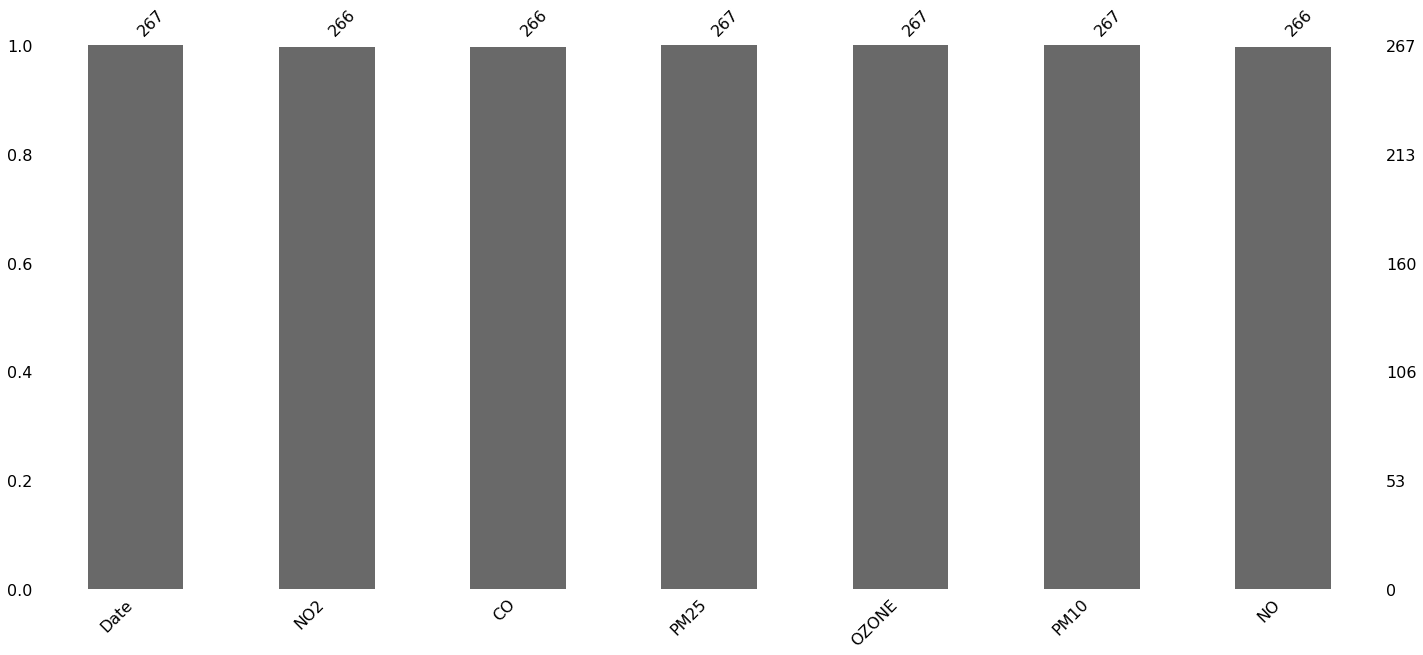

In [7]:
msno.bar(data_df)

In [8]:
# Interpolate missing data  
data_df = data_df.interpolate()
data_df

,Date,NO2,CO,PM25,OZONE,PM10,NO
0,2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005
1,2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071
2,2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083
3,2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037
4,2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094
...,...,...,...,...,...,...,...
262,2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049
263,2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054
264,2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034
265,2020-10-17,0.025,0.6520,19.1,0.047,41.2,0.014


In [9]:
#https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv
target_df = pd.read_csv('/Users/kevinmarlis/Developer/Thesis/Covid/latimes-county-totals.csv')
target_df = target_df[target_df['county'] == 'Los Angeles']
target_df = target_df[['date', 'new_confirmed_cases', 'new_deaths']]
target_df = target_df.rename(columns={"date": "Date"})
target_df["Date"] = pd.to_datetime(target_df["Date"])
target_df = target_df.sort_values("Date", ignore_index=True)
target_df = target_df[(target_df['Date'] >= start_date) & (target_df['Date'] <= end_date)] 
target_df = target_df.interpolate(method ='linear', limit_direction ='backward', limit = 1)
target_df

,Date,new_confirmed_cases,new_deaths
0,2020-01-26,0.0,0.0
1,2020-01-27,0.0,0.0
2,2020-01-28,0.0,0.0
3,2020-01-29,0.0,0.0
4,2020-01-30,0.0,0.0
...,...,...,...
262,2020-10-14,1223.0,19.0
263,2020-10-15,1201.0,22.0
264,2020-10-16,1041.0,22.0
265,2020-10-17,923.0,7.0


In [10]:
df = pd.merge(left=data_df, right=target_df)
df = df.set_index('Date', drop=True)
df

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,new_deaths
Date,,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0,0.0
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0,0.0
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0,0.0
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0,0.0
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1223.0,19.0
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1201.0,22.0
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1041.0,22.0


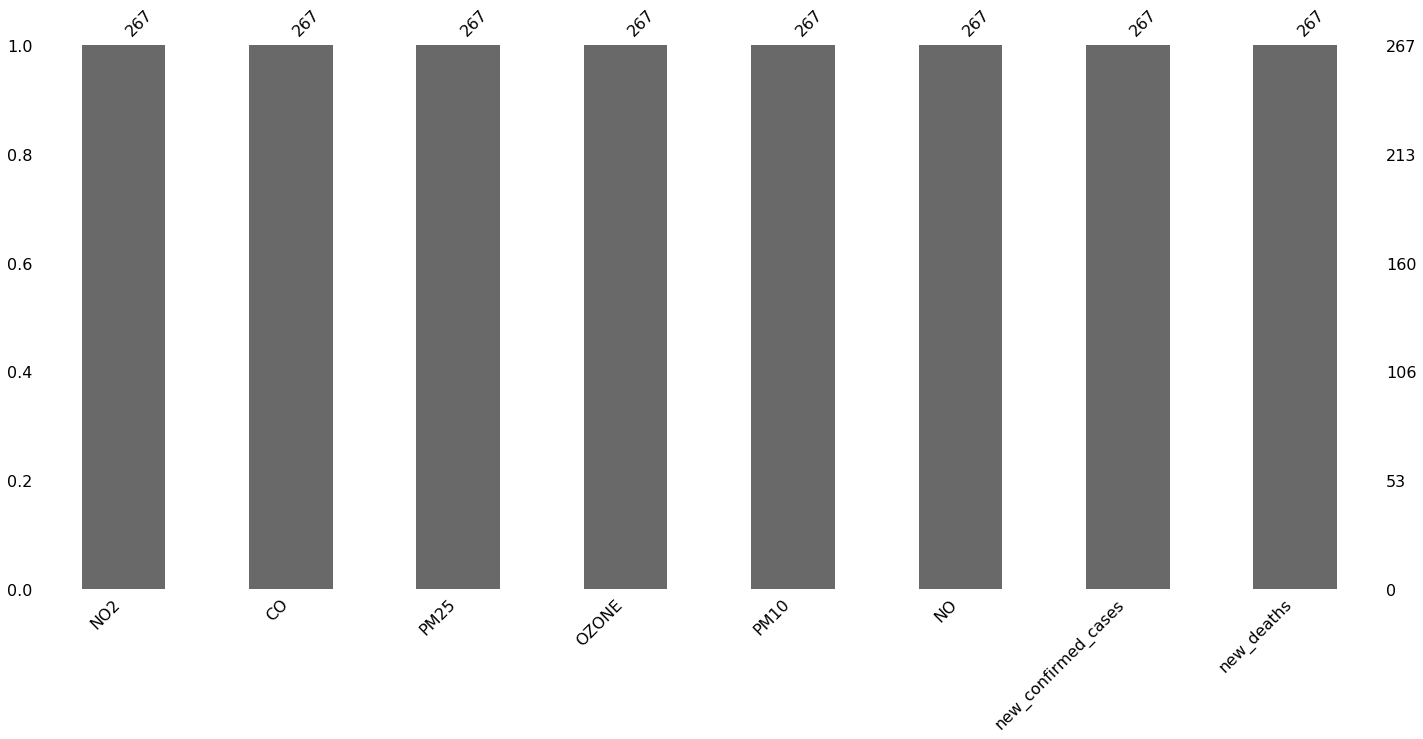

In [11]:
msno.bar(df)

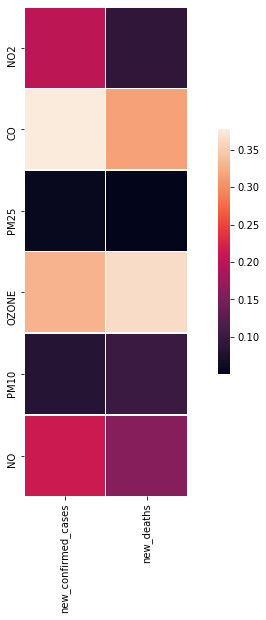

In [12]:
correlation = df.corr().abs()
correlation = correlation.drop(correlation.index[[6,7]])
correlation = correlation.drop(correlation.columns[[0,1,2,3,4,5]], axis=1)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(correlation,square=True, linewidths=.5, cbar_kws={"shrink": .5})

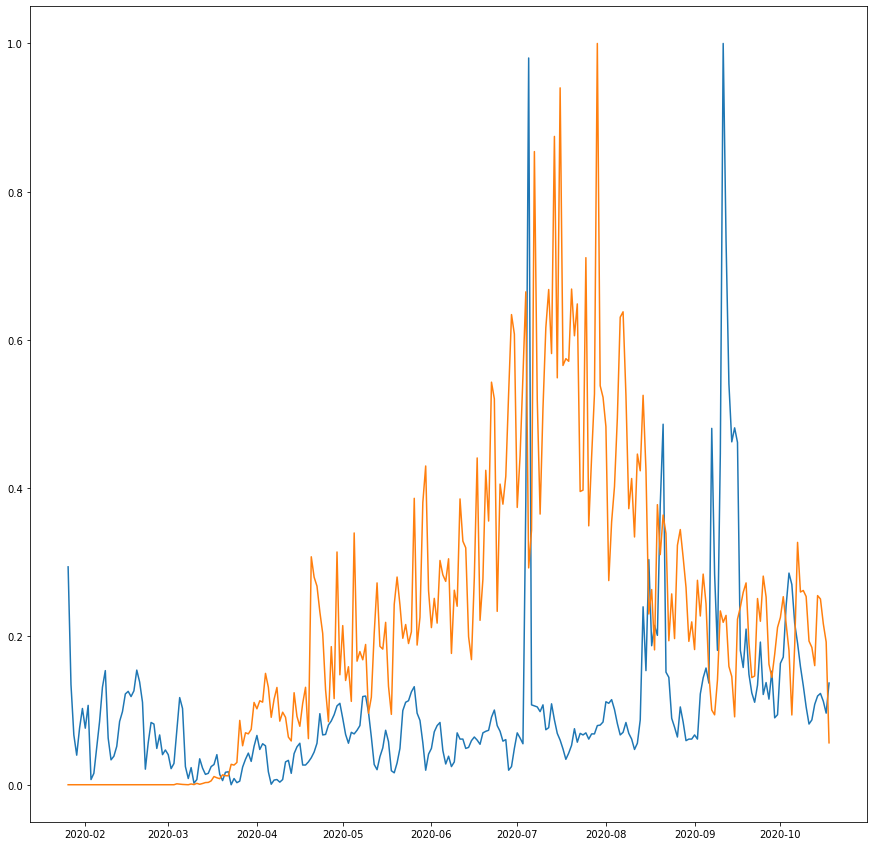

In [13]:
from sklearn import preprocessing

plt.figure(figsize=(15, 15))
plt.plot(df.index, preprocessing.minmax_scale(df['PM25'], feature_range=(0, 1), axis=0, copy=True))
plt.plot(df.index, preprocessing.minmax_scale(df['new_confirmed_cases'], feature_range=(0, 1), axis=0, copy=True))

plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fafc4b27350>,
      dtype=object)

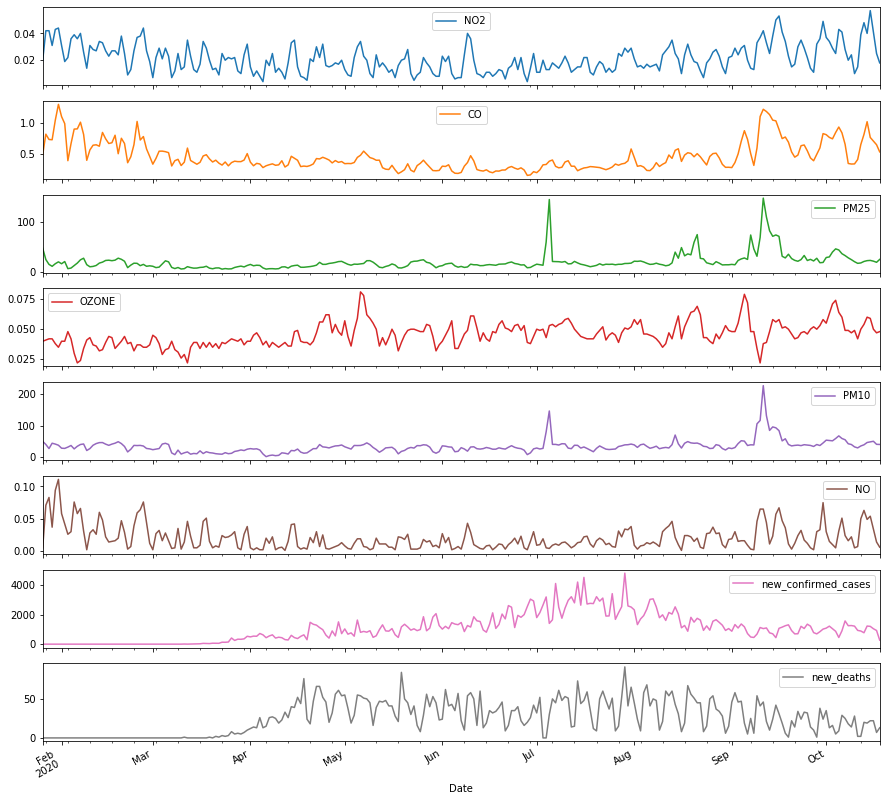

In [14]:
df.plot(subplots=True, figsize=(15, 15))

In [58]:
train = df.query('Date < "2020-09-15"')
valid = df.query('Date >= "2020-09-15" and Date < "2020-09-25"')
test = df.query('Date >= "2020-09-25"')

In [59]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [65]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

train.to_csv('processed_data/train.csv')
valid.to_csv('processed_data/valid.csv')
test.to_csv('processed_data/test.csv')

In [66]:
train = pd.read_csv('processed_data/train.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('processed_data/valid.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('processed_data/test.csv', header=0, index_col=0).values.astype('float32')

In [68]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [78]:
n_lag = 5

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

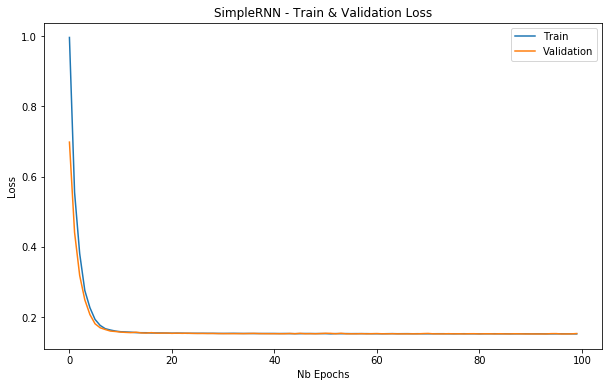

Minimum validation loss of 0.15150885978354173 reached at epoch 96


In [79]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 8)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='model/simple_rnn_weights.hdf5', 
                               verbose=0, 
                               save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', 
                             patience=10, 
                             verbose=0)
with open("model/simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen, 
                                              epochs=100, 
                                              validation_data=valid_data_gen, 
                                              verbose=0, 
                                              callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [81]:
def eval_best_model(model):
    # Load model architecture from JSON
    model_architecture = open('model/'+model+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('model/'+model+'_weights.hdf5')
    # Compile the best model
    best_model.compile(loss='mae', optimizer=RMSprop())
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_data_gen)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

eval_best_model('simple_rnn')

Loss on test data for simple_rnn : 0.187545508146286


In [118]:
data = []
data.append(list(df.loc['2020-10-11'].values))
data.append(list(df.loc['2020-10-12'].values))
data.append(list(df.loc['2020-10-13'].values))
data.append(list(df.loc['2020-10-14'].values))
data.append(list(df.loc['2020-10-15'].values))
data = [data]
prediction = simple_rnn.predict(data)